[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed. 



In [10]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [11]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Again added my own set of tools : 

In [12]:
from langchain_openai import ChatOpenAI
import math

def multiply(a: int, b: int) -> int:
    """Multiplies two numbers together."""
    return a * b

def add(a: int, b: int) -> int:
    """Adds two numbers together."""
    return a + b


def subtract(a: int, b: int) -> int:
    """Subtracts the second number from the first."""
    return a - b


def divide(a: float, b: float) -> float:
    """Divides the first number by the second. Returns an error if division by zero."""
    if b == 0:
        return "Error: Cannot divide by zero."
    return a / b


def factorial(n: int) -> int:
    """Calculates the factorial of a non-negative integer."""
    if n < 0:
        return "Error: Factorial is not defined for negative numbers."
    return math.factorial(n)

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([add, subtract, multiply, divide, factorial])

## added the tools to the conditional node and set up the graph

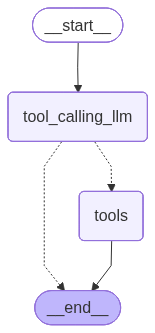

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([add, subtract, multiply, divide, factorial]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## testing out the graph with my prompts

In [14]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 8 factorial?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 8 factorial?
================================== Ai Message ==================================
Tool Calls:
  factorial (call_xBEOBG0ZY4dxc06MTo9Q0iXh)
 Call ID: call_xBEOBG0ZY4dxc06MTo9Q0iXh
  Args:
    n: 8
================================= Tool Message =================================
Name: factorial

40320


## used two tools together in a single command, factorial and division

In [15]:
messages = [HumanMessage(content="Heyo bro, what is division of 18 by factorial of 3?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Heyo bro, what is division of 18 by factorial of 3?
================================== Ai Message ==================================
Tool Calls:
  divide (call_wz7Z9UhrJHb1fegL6Pi6DpW1)
 Call ID: call_wz7Z9UhrJHb1fegL6Pi6DpW1
  Args:
    a: 18
    b: 6
  factorial (call_pc1eQ890js1vMRGIelnnGmLx)
 Call ID: call_pc1eQ890js1vMRGIelnnGmLx
  Args:
    n: 3
================================= Tool Message =================================
Name: divide

3.0
================================= Tool Message =================================
Name: factorial

6


In [16]:
messages = [HumanMessage(content="what is  product of 6 and 7")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is  product of 6 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZwJdU70fOThaooArkzvriXBt)
 Call ID: call_ZwJdU70fOThaooArkzvriXBt
  Args:
    a: 6
    b: 7
================================= Tool Message =================================
Name: multiply

42


In [17]:
messages = [HumanMessage(content="what is the difference of 6 and 7")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the difference of 6 and 7
================================== Ai Message ==================================
Tool Calls:
  subtract (call_HQIp18ZkNYIro5gyQWAHXxhd)
 Call ID: call_HQIp18ZkNYIro5gyQWAHXxhd
  Args:
    a: 6
    b: 7
================================= Tool Message =================================
Name: subtract

-1


## Successfully made the changes to thr router file :

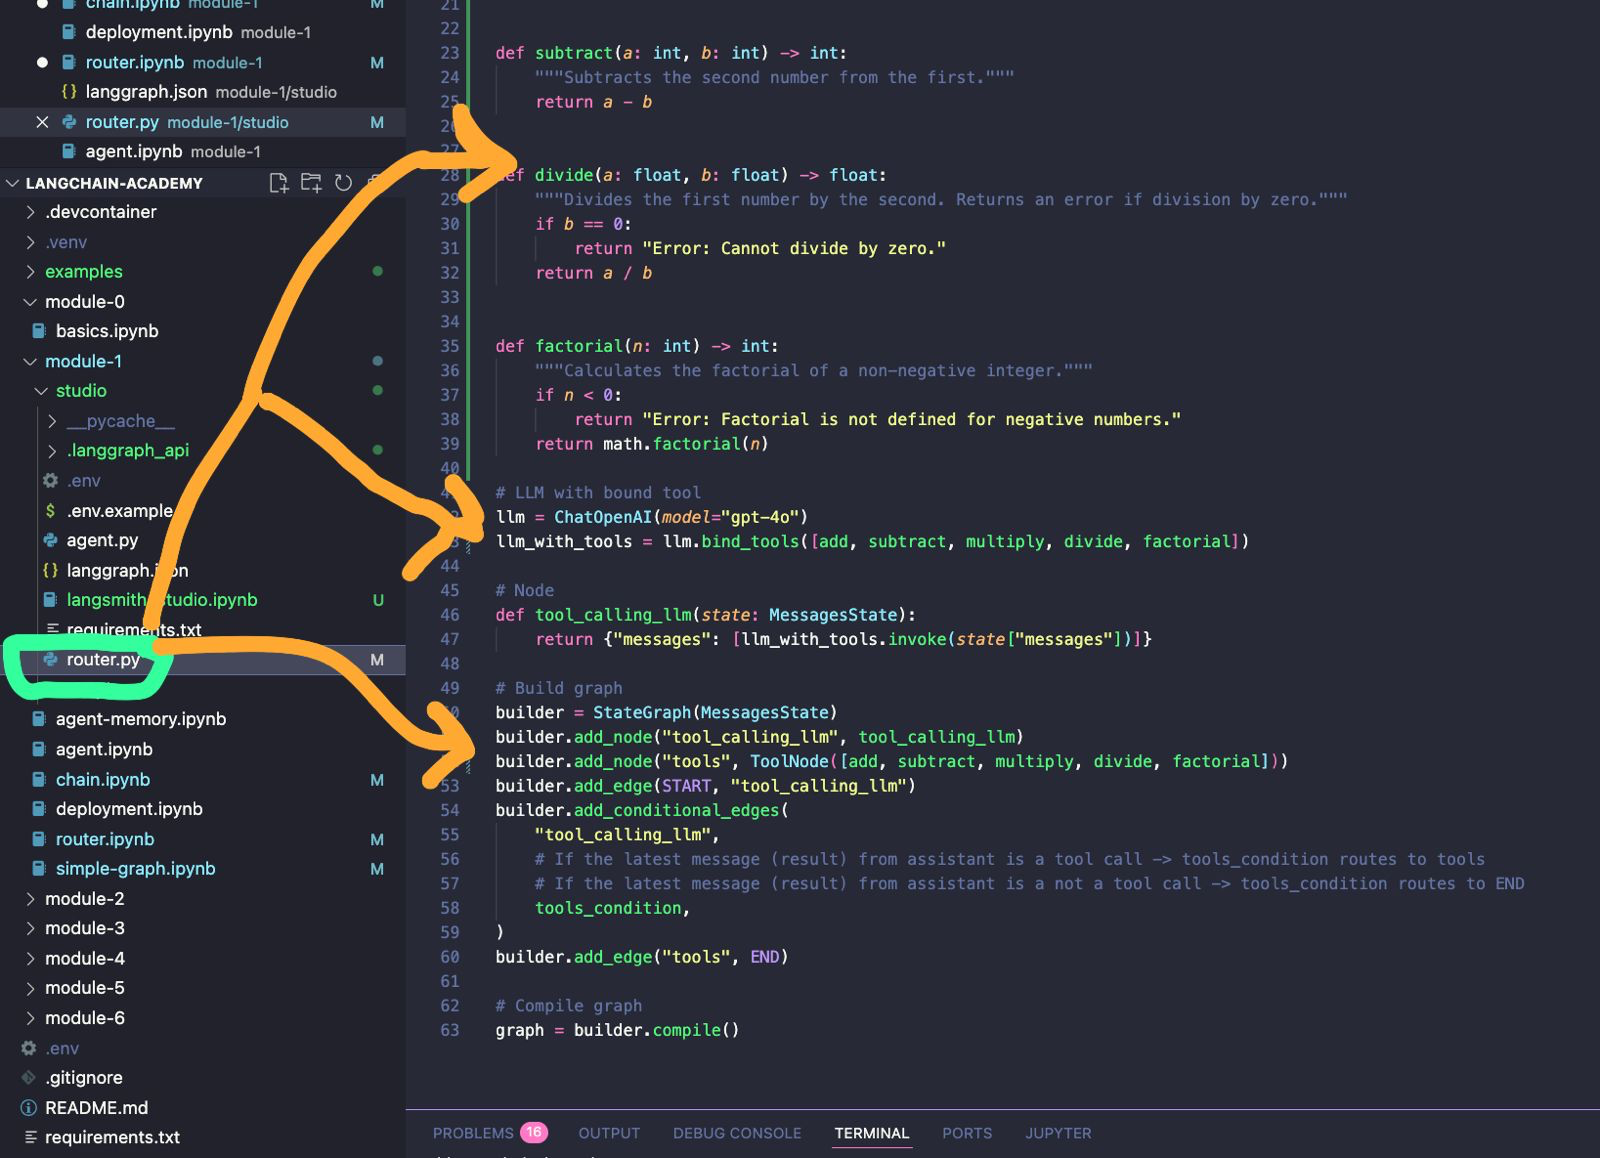

## We can see our router in the Langsmith studio
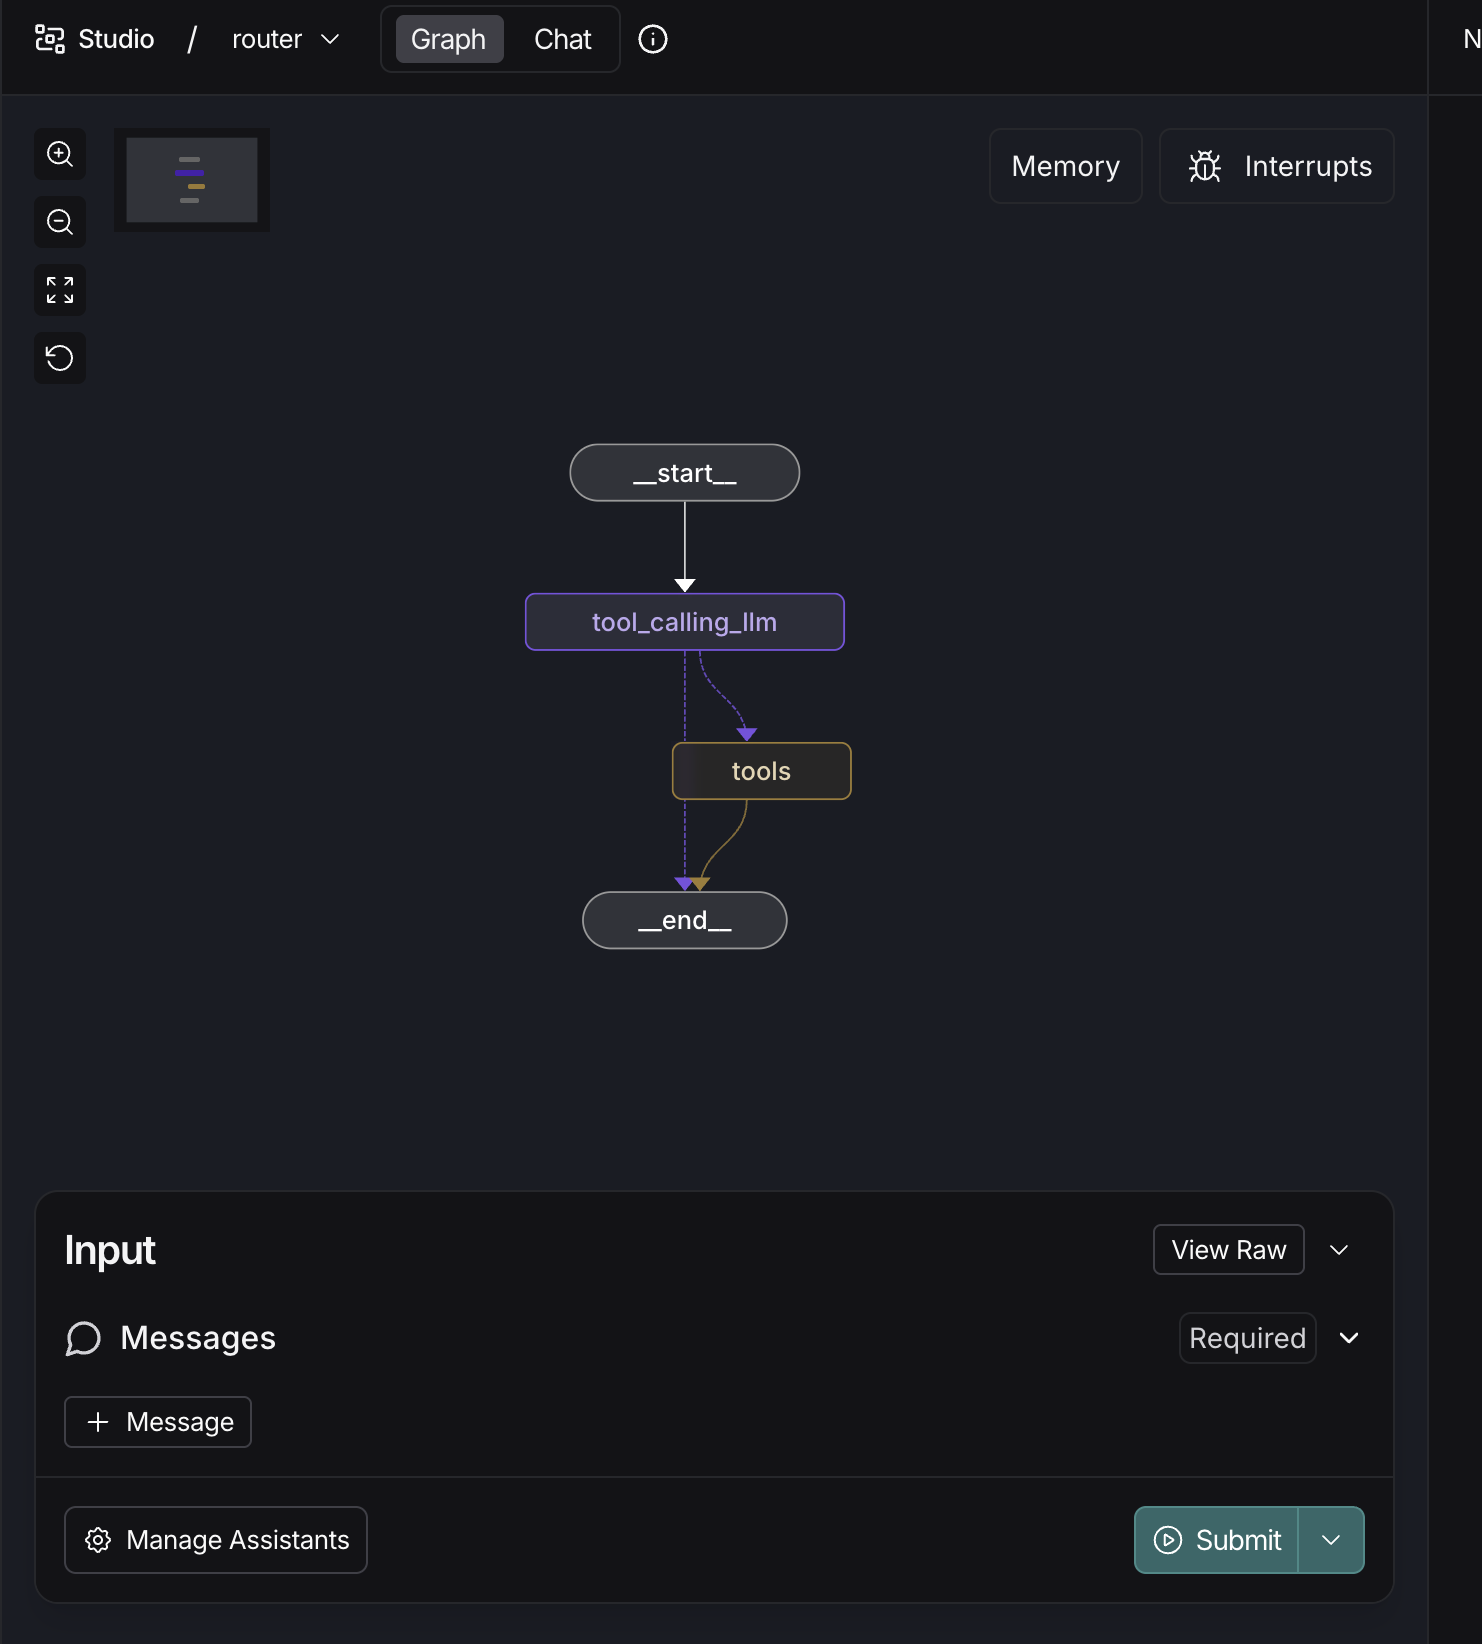

## when I asked a question which didnt require the tool, I can see under TURN1 that the tools edge wasn't used

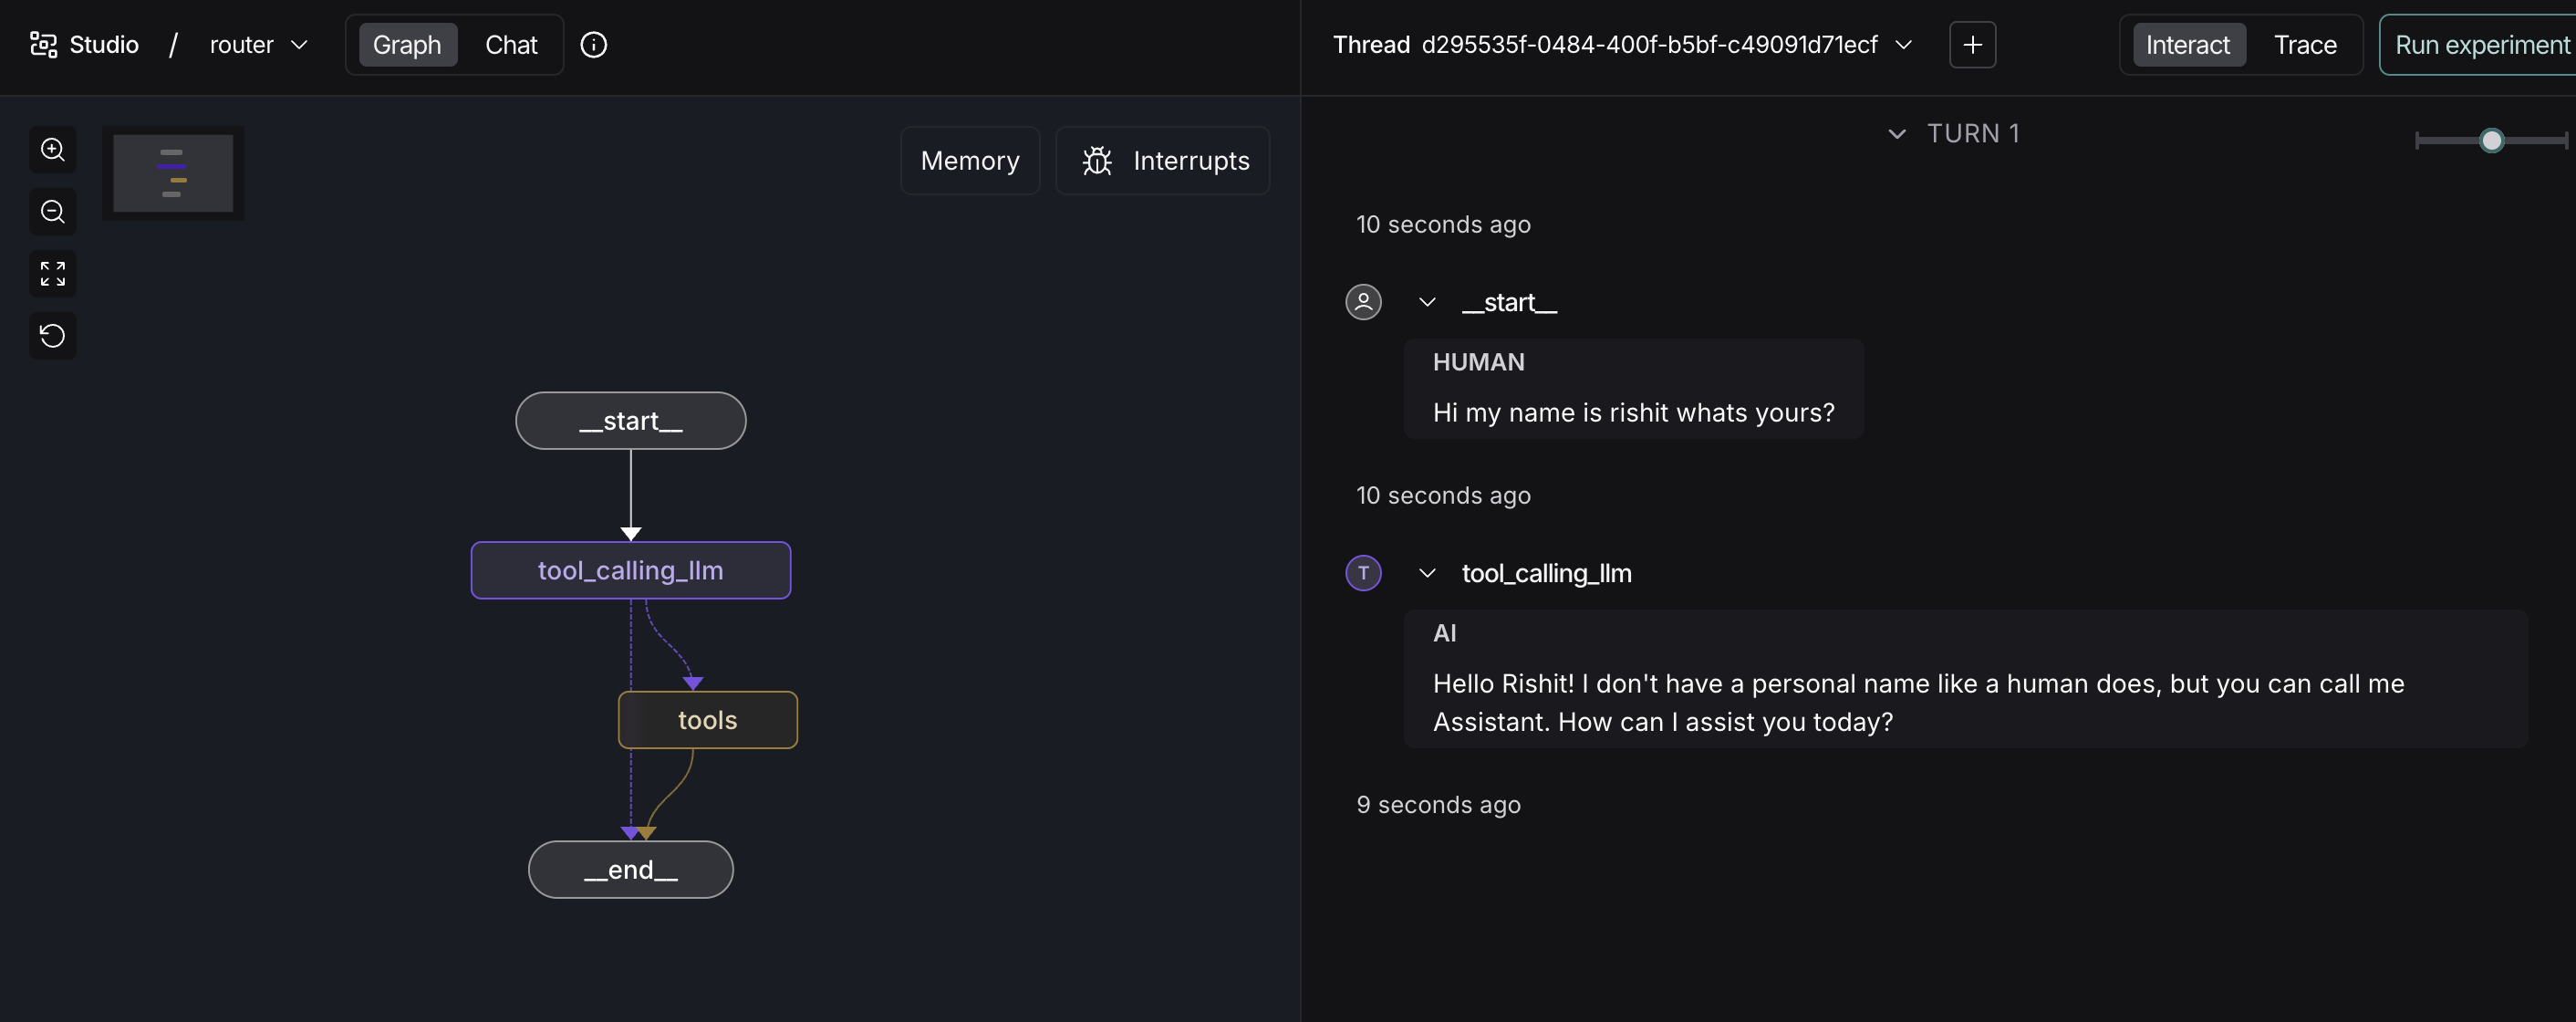

## Here we have asked it a question which requires it to call the tool edge and we can see that it does call the tool :

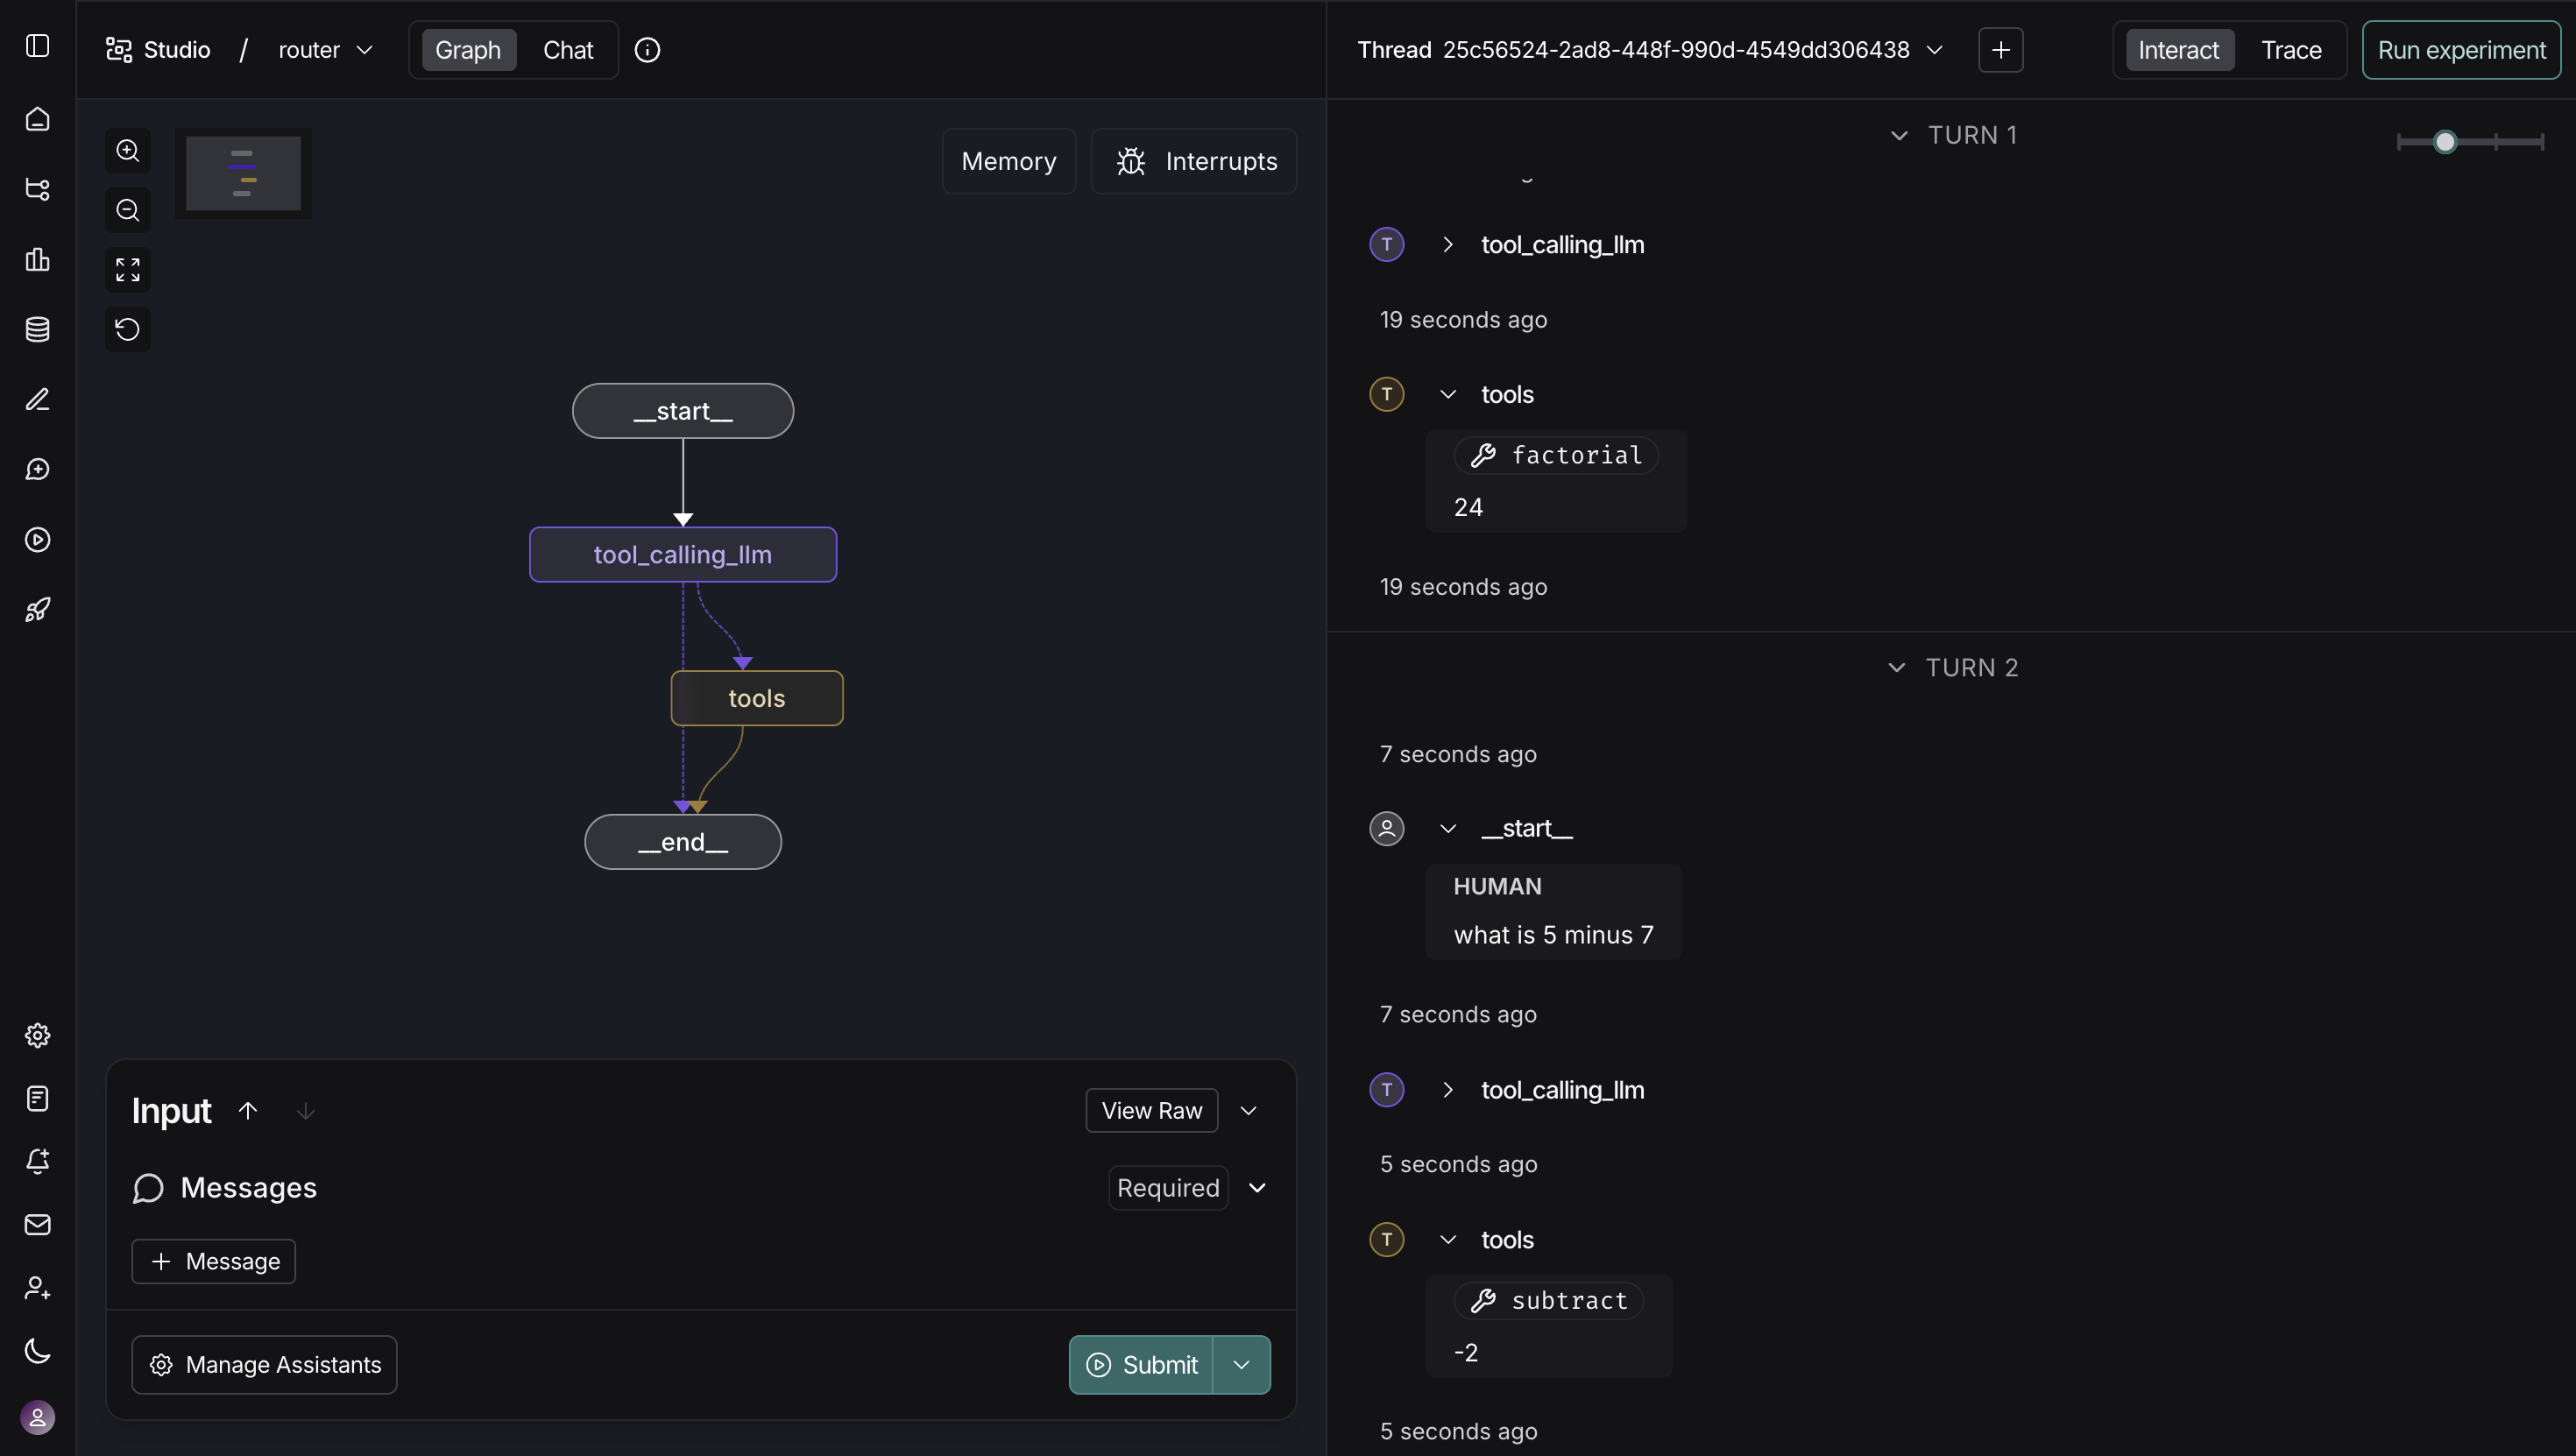